2025-08-29 15:28:43.480555: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-29 15:28:43.480833: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-29 15:28:43.519374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-29 15:28:44.434361: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

 Processing val images (removing background & setting black)


.: 0it [00:00, ?it/s]
Magnifera_indica: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]
E0000 00:00:1756461559.694015   43493 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1756461559.734896   43493 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 Background removal complete.

 Model loaded.
Detected: categorical classification.

Found 45 images belonging to 5 classes.


/home/prathamesh/miniconda3/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


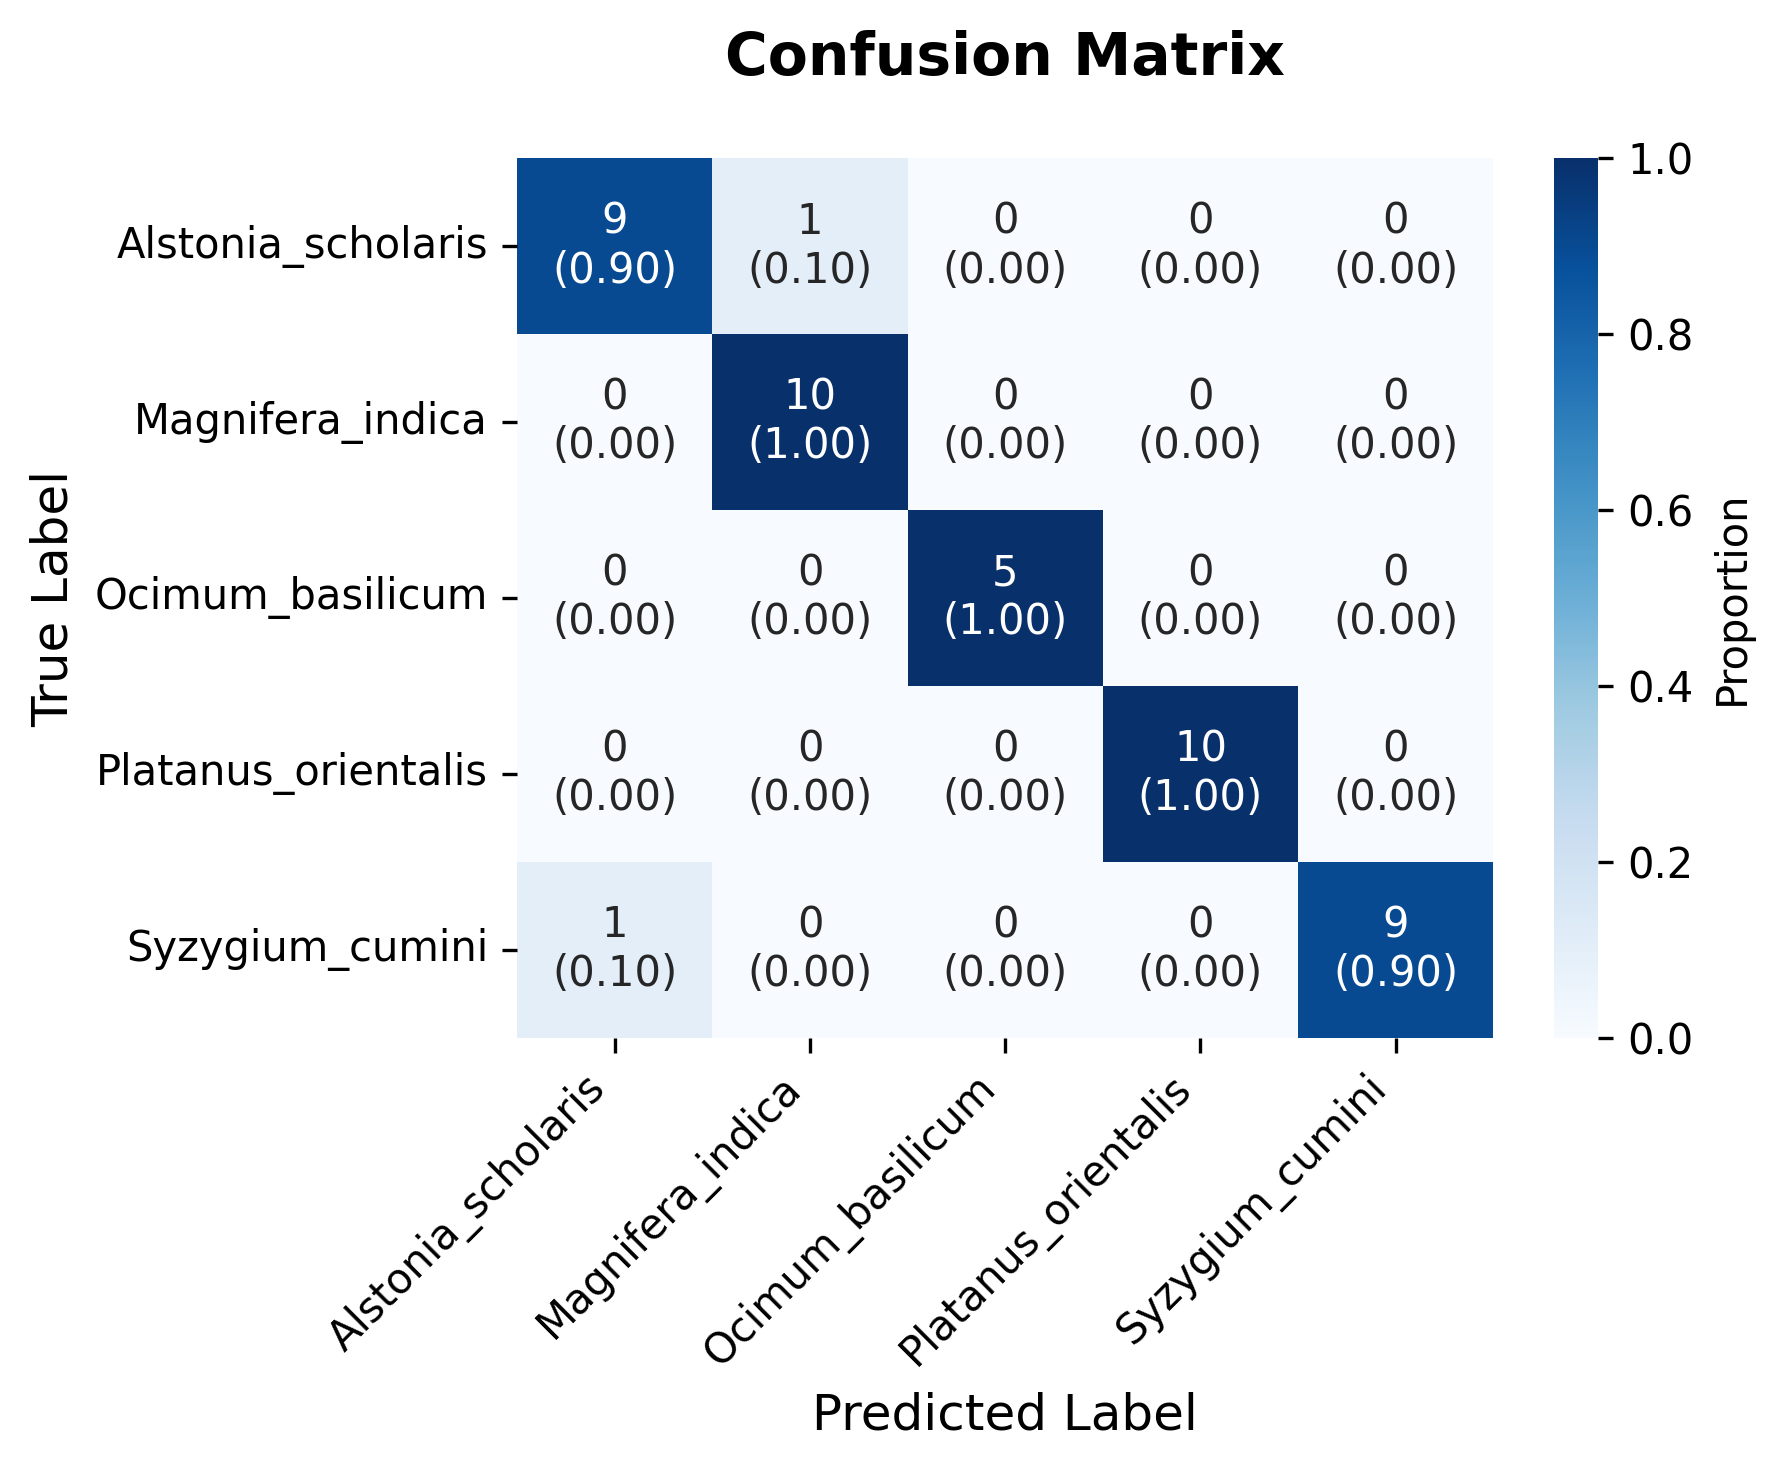

Classification Report:

                     precision    recall  f1-score   support

 Alstonia_scholaris     0.9000    0.9000    0.9000        10
   Magnifera_indica     0.9091    1.0000    0.9524        10
   Ocimum_basilicum     1.0000    1.0000    1.0000         5
Platanus_orientalis     1.0000    1.0000    1.0000        10
    Syzygium_cumini     1.0000    0.9000    0.9474        10

           accuracy                         0.9556        45
          macro avg     0.9618    0.9600    0.9599        45
       weighted avg     0.9576    0.9556    0.9555        45



In [1]:
import os
import io
import numpy as np
from PIL import Image
from rembg import remove
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
model_path = "/home/prathamesh/Documents/IDC409_Project/dataset/models/leaf_cnn_model.keras"
val_dir = "/home/prathamesh/Documents/IDC409_Project/dataset/valid"
processed_val_dir = "home/prathamesh/Documents/IDC409_Project/dataset/Validation_BGR"

os.makedirs(processed_val_dir, exist_ok=True)

# Remove background + set black 
print(" Processing val images (removing background & setting black)")
for root, _, files in os.walk(val_dir):
    rel_path = os.path.relpath(root, val_dir)
    out_subdir = os.path.join(processed_val_dir, rel_path) if rel_path != "." else processed_val_dir
    os.makedirs(out_subdir, exist_ok=True)

    for file in tqdm(files, desc=rel_path or "root"):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        in_path = os.path.join(root, file)
        out_path = os.path.join(out_subdir, file)

        try:
            with open(in_path, "rb") as f:
                input_bytes = f.read()
            result = remove(input_bytes)  # remove background
            img_no_bg = Image.open(io.BytesIO(result)).convert("RGBA")

            # black background
            black_bg = Image.new("RGBA", img_no_bg.size, (0, 0, 0, 255))
            black_bg.paste(img_no_bg, (0, 0), img_no_bg)
            black_bg = black_bg.convert("RGB")
            black_bg.save(out_path, quality=95)
        except Exception as e:
            print(f" FAILED {in_path}: {e}")

print(" Background removal complete.\n")

# Load model
model = load_model(model_path)
print(" Model loaded.")

# Detect classification type
output_units = model.output_shape[-1]
classification_type = "binary" if output_units == 1 else "categorical"
print(f"Detected: {classification_type} classification.\n")

# Prepare validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    processed_val_dir,
    target_size=(224, 224),  # match training size
    batch_size=32,
    class_mode='binary' if classification_type == "binary" else 'categorical',
    shuffle=False
)

# Predictions 
y_pred_probs = model.predict(val_generator)

if classification_type == "binary":
    y_pred = (y_pred_probs > 0.5).astype("int32").ravel()
else:
    y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(val_generator.class_indices.keys())
y_true = val_generator.classes


# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize for proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Combine counts and proportions in annotations
annot_labels = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot_labels[i, j] = f"{cm[i, j]}\n({cm_normalized[i, j]:.2f})"
        
# Plot confusion matrix
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(
    cm_normalized,
    annot=annot_labels,
    fmt='',
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar_kws={'label': 'Proportion'}
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Added spacing with pad
plt.title("Confusion Matrix", fontsize=14, weight='bold', pad=20)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("Classification Report:\n")
print(report)



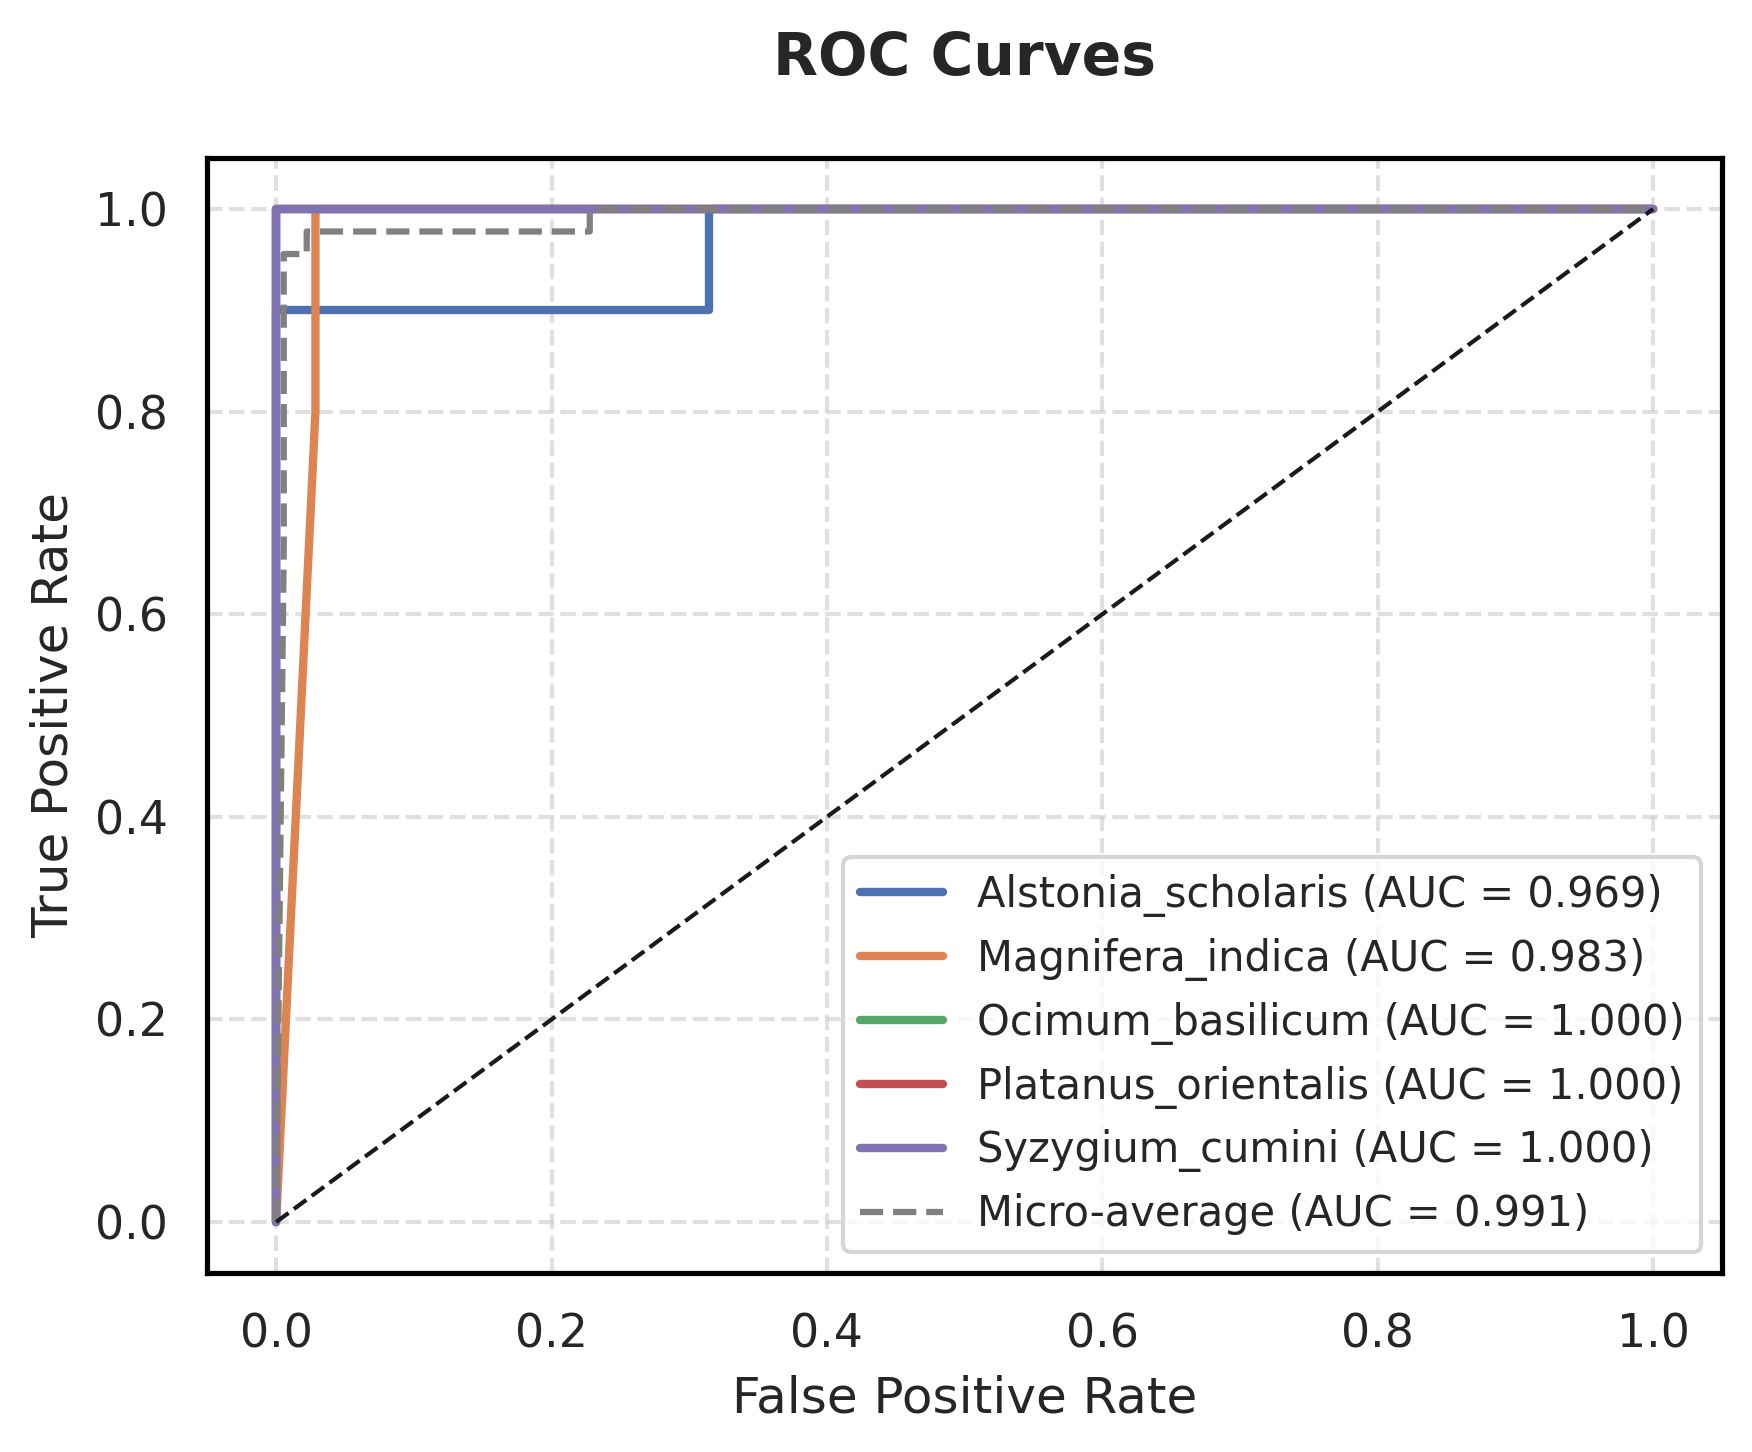

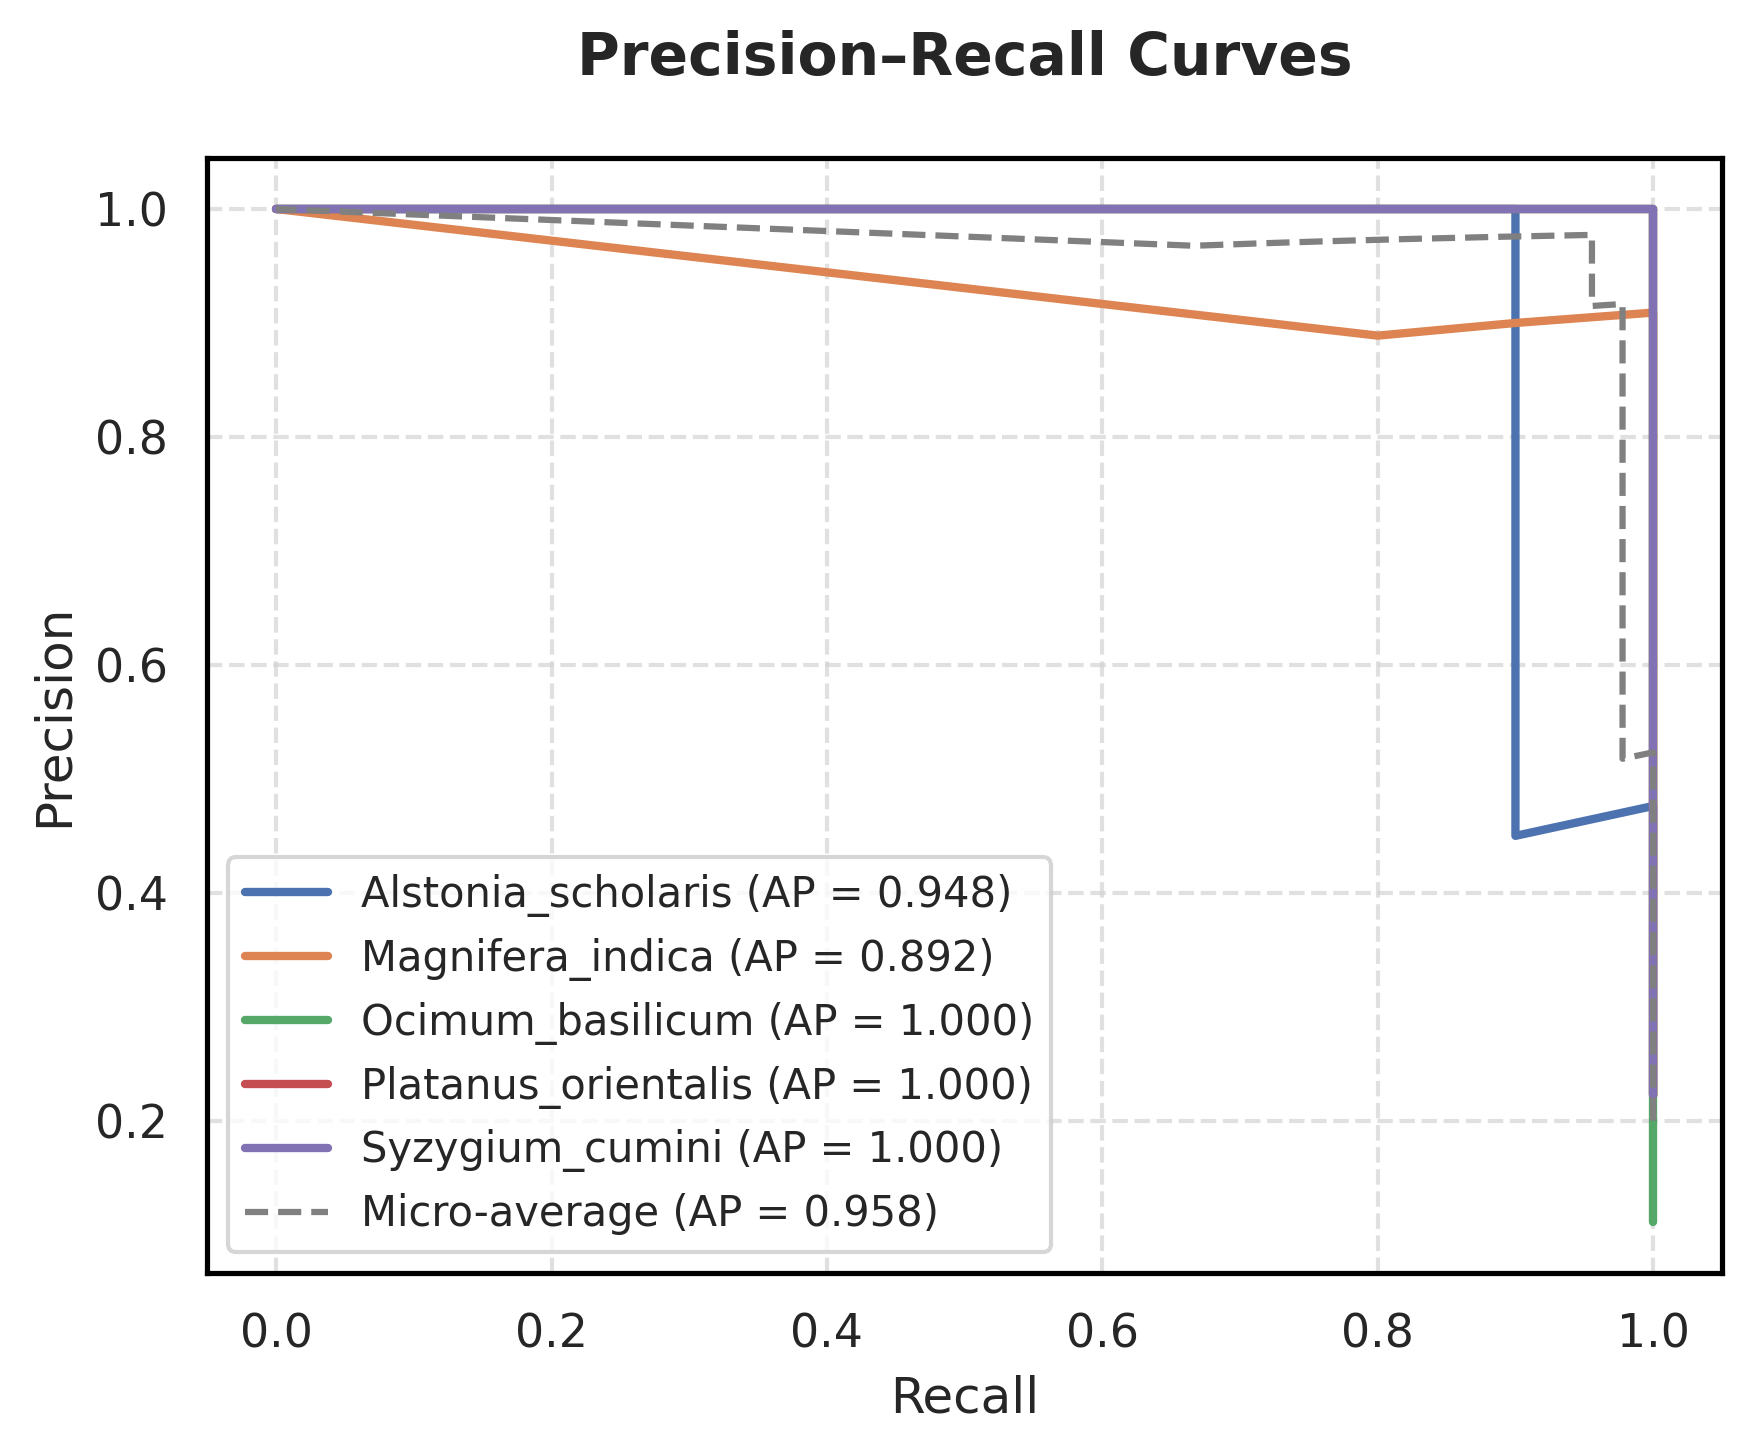

Cohen's Kappa: 0.9437
Matthews Correlation Coefficient: 0.9443
Balanced Accuracy: 0.9600
Alstonia_scholaris - Sensitivity: 0.9000, Specificity: 0.9714
Magnifera_indica - Sensitivity: 1.0000, Specificity: 0.9714
Ocimum_basilicum - Sensitivity: 1.0000, Specificity: 1.0000
Platanus_orientalis - Sensitivity: 1.0000, Specificity: 1.0000
Syzygium_cumini - Sensitivity: 0.9000, Specificity: 1.0000


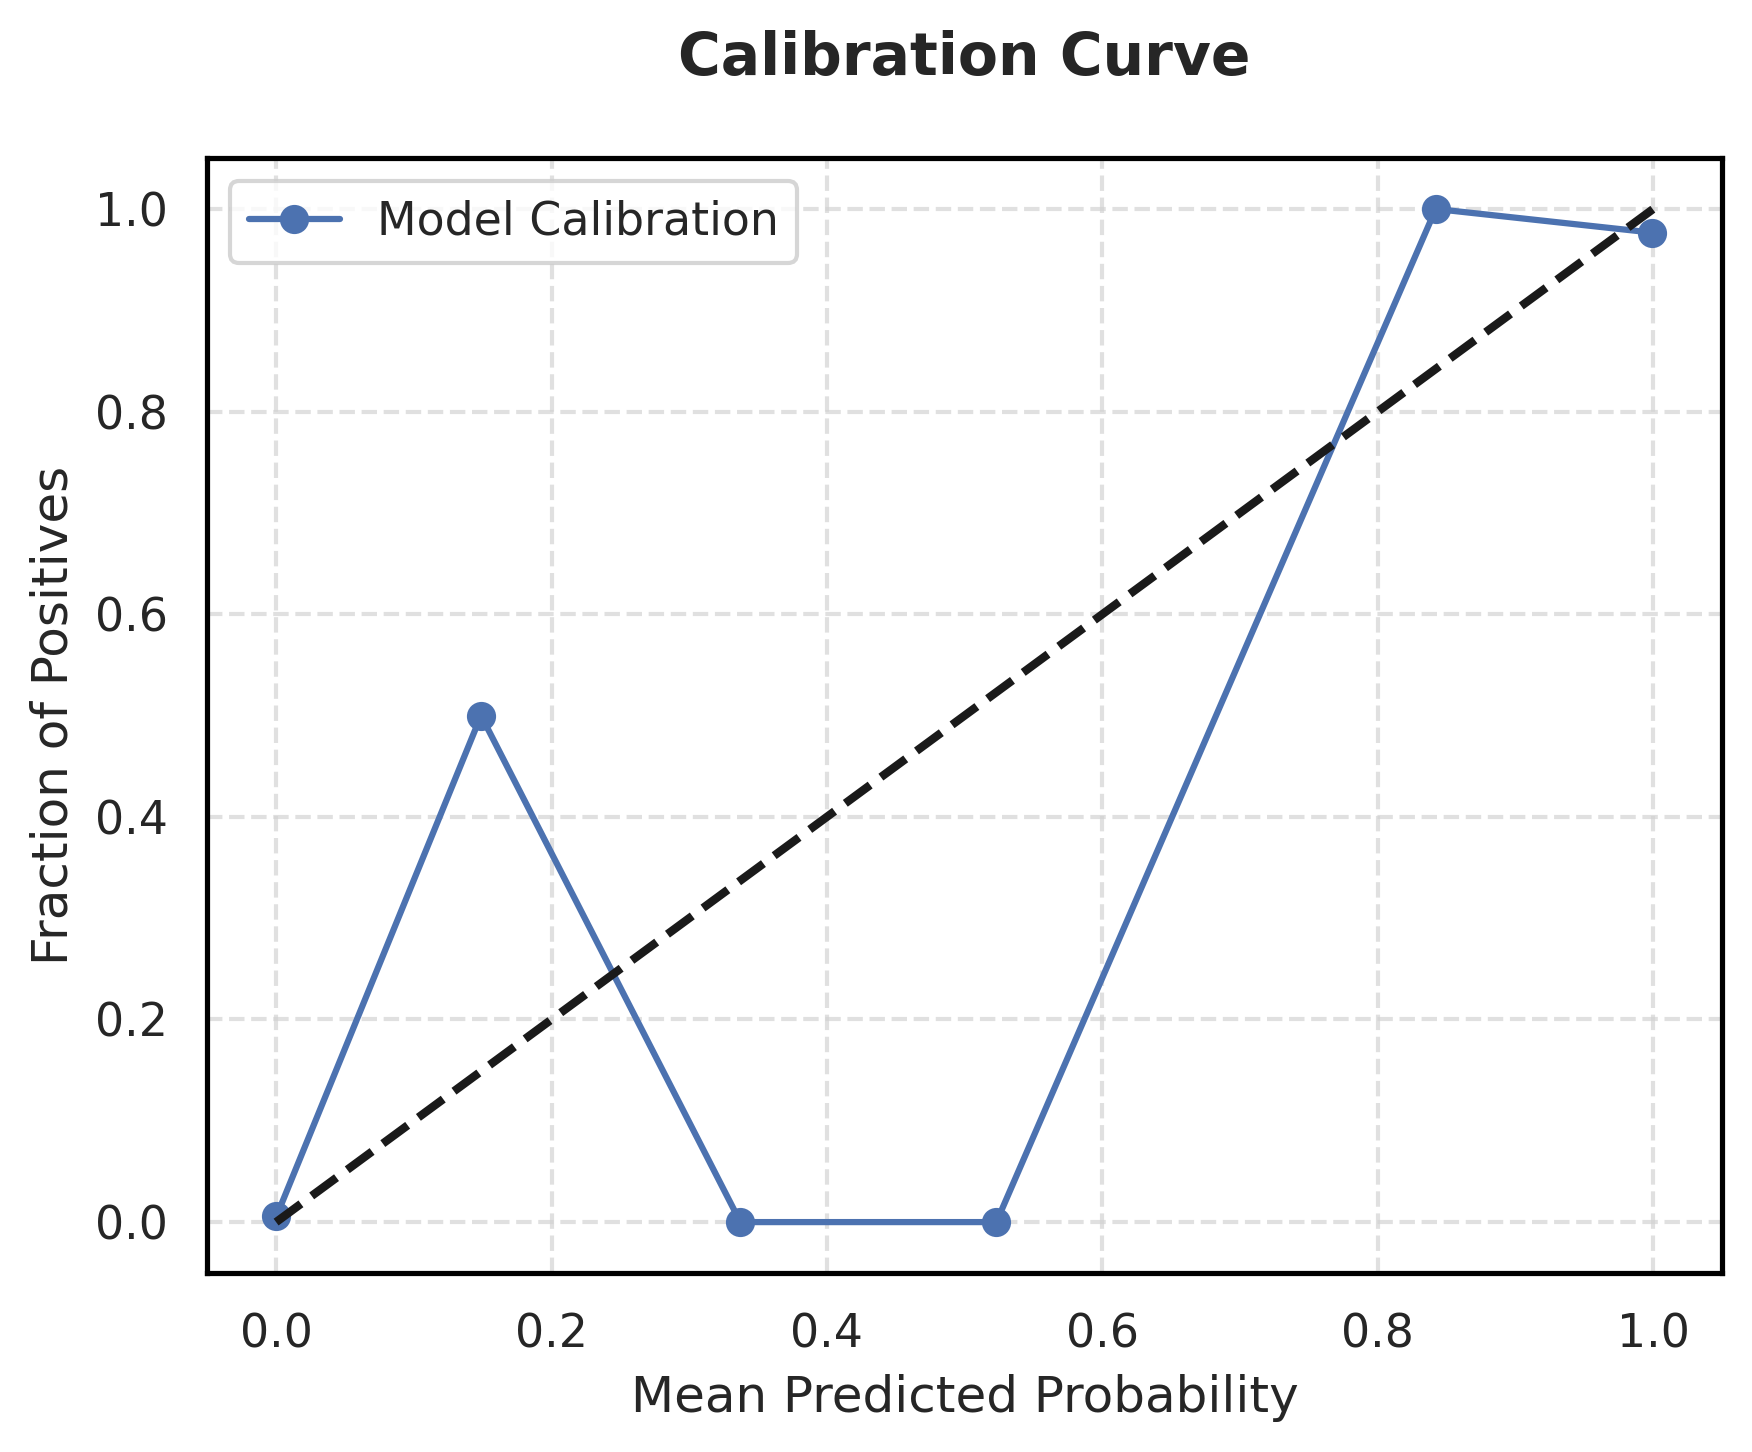

Number of misclassified samples: 2 out of 45 total


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")  # or "white", "darkgrid", etc.
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",  # ensures no seaborn gray background
    "axes.edgecolor": "black",
    "axes.grid": True,
    "grid.color": "lightgray",
    "grid.linestyle": "--",
    "grid.alpha": 0.7,
    "figure.dpi": 300
})

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score, cohen_kappa_score,
    matthews_corrcoef, balanced_accuracy_score
)
from sklearn.calibration import calibration_curve
import tensorflow as tf

# ROC Curves & AUC
n_classes = len(class_labels)
y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

plt.figure(figsize=(6, 5), dpi=300)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f"{class_labels[i]} (AUC = {roc_auc:.3f})")

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', color='gray', label=f"Micro-average (AUC = {roc_auc_micro:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14, weight='bold', pad=20)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


# Precision–Recall Curves
plt.figure(figsize=(6, 5), dpi=300)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    ap_score = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, linewidth=2, label=f"{class_labels[i]} (AP = {ap_score:.3f})")

# Micro-average PR
precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_probs.ravel())
ap_micro = average_precision_score(y_true_bin, y_pred_probs, average="micro")
plt.plot(recall_micro, precision_micro, linestyle='--', color='gray', label=f"Micro-average (AP = {ap_micro:.3f})")

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision–Recall Curves', fontsize=14, weight='bold', pad=20)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional Metrics
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)

print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")

# Class-wise Sensitivity & Specificity
sensitivities = cm.diagonal() / cm.sum(axis=1)  # Recall per class
specificities = []
for i in range(len(class_labels)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificities.append(tn / (tn + fp))

for idx, label in enumerate(class_labels):
    print(f"{label} - Sensitivity: {sensitivities[idx]:.4f}, Specificity: {specificities[idx]:.4f}")

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_true_bin.ravel(), y_pred_probs.ravel(), n_bins=10)
plt.figure(figsize=(6, 5), dpi=300)
plt.plot(prob_pred, prob_true, marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("Mean Predicted Probability", fontsize=12)
plt.ylabel("Fraction of Positives", fontsize=12)
plt.title("Calibration Curve", fontsize=14, weight='bold', pad=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Misclassification Summary
misclassified_idx = np.where(y_true != y_pred)[0]
print(f"Number of misclassified samples: {len(misclassified_idx)} out of {len(y_true)} total")
